<a href="https://colab.research.google.com/github/valentinaechavarria/-web-traffic-forecasting-project/blob/develop/1_entregaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Necessary Imports for the project

A continuacion importamos las librerias necesarias para trabajar con los datos.

In [43]:
!pip install pystan~=2.14
!pip install fbprophet
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Creamos las credenciales para poder descargar los datos de Kaggle. 

In [45]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"felipecadavidrincn","key":"d9b9503283bc4582046878ec6ea10ccf"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [46]:
%%bash
export KAGGLE_CONFIG_DIR=~/.kaggle/
kaggle competitions download web-traffic-time-series-forecasting -f key_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f key_2.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f sample_submission_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f sample_submission_2.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f train_1.csv.zip
kaggle competitions download web-traffic-time-series-forecasting -f train_2.csv.zip

key_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
key_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


Aca podemos evidenciar que los datos estan cargados y descomprimidos correctamente

In [47]:
cd /content

/content


In [48]:
!unzip -o key_1.csv.zip
!unzip -o key_2.csv.zip
!unzip -o sample_submission_1.csv.zip
!unzip -o sample_submission_2.csv.zip
!unzip -o train_1.csv.zip
!unzip -o train_2.csv.zip

Archive:  key_1.csv.zip
  inflating: key_1.csv               
Archive:  key_2.csv.zip
  inflating: key_2.csv               
Archive:  sample_submission_1.csv.zip
  inflating: sample_submission_1.csv  
Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  
Archive:  train_1.csv.zip
  inflating: train_1.csv             
Archive:  train_2.csv.zip
  inflating: train_2.csv             


In [49]:
ls

key_1.csv      sample_submission_1.csv      train_1.csv.zip
key_1.csv.zip  sample_submission_1.csv.zip  train_2.csv
key_2.csv      sample_submission_2.csv*     train_2.csv.zip
key_2.csv.zip  sample_submission_2.csv.zip
sample_data/   train_1.csv


# 1. Importing and Analyzing Data - Initial Approach

Aqui empezamos por analizar los datos que necesitamos para el forecasting



In [50]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math

%matplotlib inline

train = pd.read_csv("/content/train_1.csv")
keys = pd.read_csv("/content/key_1.csv")
ss = pd.read_csv("/content/sample_submission_1.csv")

In [51]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### Null Values

Hay datos que estan Null, si examinamos la longitud de los archivos de entrenamiento, resulta que son 145063 filas, y cuando vemos lo que se debe predecir, son 62 días, esto nos lleva a inferir que no todas las paginas tienen visitas todos los dias por que la longitud de los archivos no coincide (Deberian ser 8993906).

Esto significa que cada página debe indicar su predicción para cada uno de los 62 días y  los 145063 son series temporales individuales para cada página visitada

In [54]:
print("Total NaN Values: ", train.shape[0])
nan_values = train[train.isnull().any(axis=1)]
print("Total Records that are NaN: ", nan_values.shape[0])
nan_values.iloc[np.r_[0:10, len(nan_values)-10:len(nan_values)]]

Total NaN Values:  145063
Total Records that are NaN:  27786


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
10,ASTRO_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,11.0,38.0,85.0,79.0,30.0,14.0,10.0,38.0,12.0,51.0
13,AlphaGo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,14.0,17.0,19.0,56.0,21.0,13.0,21.0,11.0
19,B-PROJECT_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,26.0,10.0,5.0,5.0,11.0,10.0,4.0,8.0,6.0
24,BLACK_PINK_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,56.0,39.0,65.0,78.0,143.0,96.0,63.0,28.0,75.0
27,Beautiful_Mind_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,8.0,6.0,7.0,2.0,11.0,11.0,29.0,12.0,14.0
37,Dear_My_Friends_zh.wikipedia.org_all-access_sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,12.0,8.0,12.0,3.0,10.0,21.0,6.0,8.0,9.0
38,Doctors_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,19.0,175.0,17.0,21.0,30.0,65.0,70.0,18.0,68.0
48,Fantastic_Duo_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,16.0,15.0,11.0,10.0,7.0,12.0,9.0,8.0,10.0


### Visualizing the Data

A continuacion mostramos algunas series temporales por pagiona, en las cuales se pueden evidenciar los datos faltantes que hay fechas en las cuales no hay visitas. 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32043 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31291 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_

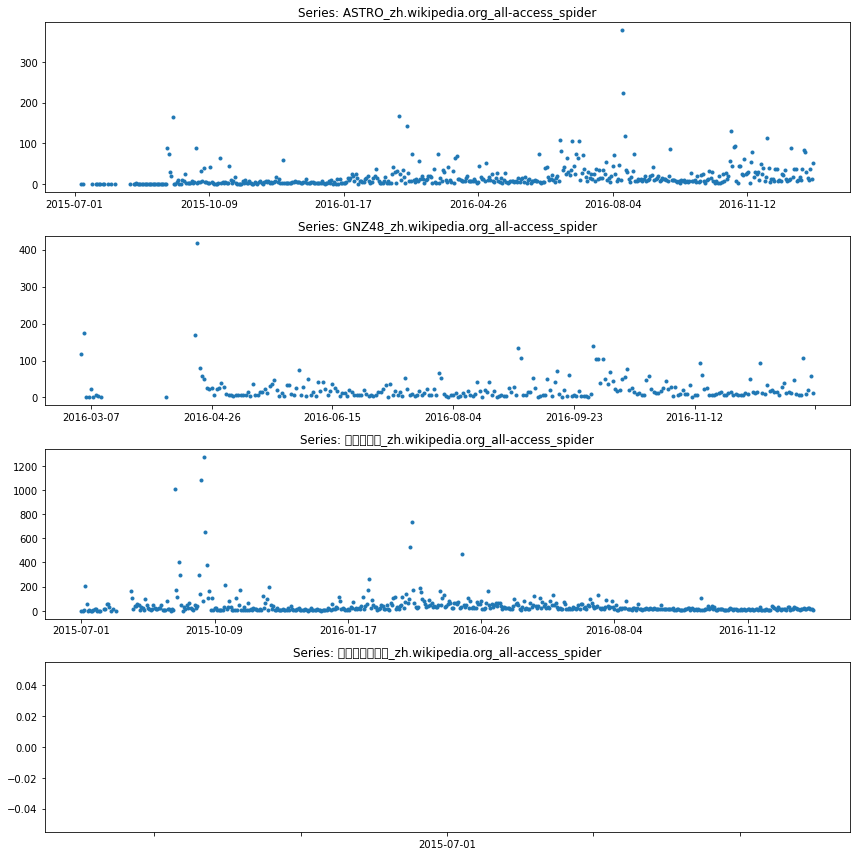

In [55]:
def plot_time_series(df, row_num, start_col =1, ax=None):
    if ax is None:
            fig = plt.figure(facecolor='w', figsize=(10, 6))
            ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        
    series_title = df.iloc[row_num, 0]
    sample_series = df.iloc[row_num, start_col:]
    sample_series.plot(style=".", ax=ax)
    ax.set_title("Series: %s" % series_title)

fig, axs  = plt.subplots(4,1,figsize=(12,12))
plot_time_series(nan_values, 2, ax=axs[0])
plot_time_series(nan_values, 15, ax=axs[1])
plot_time_series(nan_values, 100, ax=axs[2])
plot_time_series(nan_values, 1005, ax=axs[3])

plt.tight_layout()


Existen paginas que nisiquieran tienen visitas en lo absoluto

In [57]:
nan_values.iloc[1000:1010]


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4295,李宏毅_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4296,迪玛希·库达依别列根_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4297,7日羅曼史_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,漫漫回家路_(2016年電影)_zh.wikipedia.org_all-access_sp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4299,為了與你相遇_(電影)_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4300,小林家的龍女僕_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301,曹晏豪_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4302,徐鈞浩_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4303,生化危機7_惡靈古堡_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4304,A_LIFE～深愛的人～_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Discovering Data Fields for different analysis

Como se mencionó en una entrega anterior, el campo que representa la pagina; en realidad contiene varios datos diferentes que podemos usar para representar mejor la informacion y hacer distintos analsis



In [58]:
import re

def split_page_attributes(str):
    fields = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if fields is not None:
        return fields.group(1), fields.group(2), fields.group(3), fields.group(4)
    else:
        return "", "", "", ""


print(split_page_attributes("91Days_zh.wikipedia.org_all-access_spider"))
print(split_page_attributes("Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider"))

('91Days', 'zh', 'all-access', 'spider')
('Resident_Evil:_Capítulo_Final', 'es', 'all-access', 'spider')


Hacemos el siguiente analisis por tipo de pagina

In [59]:
page_attributes = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')
page_attributes[0:10]

,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider
